In [1]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt


import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score


import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")
import datetime
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [4]:
df1 = df.dropna()

In [5]:
df1.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

In [6]:
df1["CustomerID"] = df1["CustomerID"].astype("int64")

In [7]:
df2 = df1[df1.Quantity>0]

In [8]:
df2['AmountSpent'] = df2['Quantity']*df2['UnitPrice']

In [9]:
df2 = df2[['InvoiceNo','InvoiceDate','StockCode','Description','Quantity','UnitPrice','AmountSpent','CustomerID','Country']]

In [10]:
df2.insert(loc=2, column='Year_Month', value=df2['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df2.insert(loc=3, column='Month', value=df2.InvoiceDate.dt.month)
df2.insert(loc=4, column='Day', value=(df2.InvoiceDate.dt.dayofweek)+1)
df2.insert(loc=5, column='Hour', value=df2.InvoiceDate.dt.hour)

In [11]:
df2.head()

,InvoiceNo,InvoiceDate,Year_Month,Month,Day,Hour,StockCode,Description,Quantity,UnitPrice,AmountSpent,CustomerID,Country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom


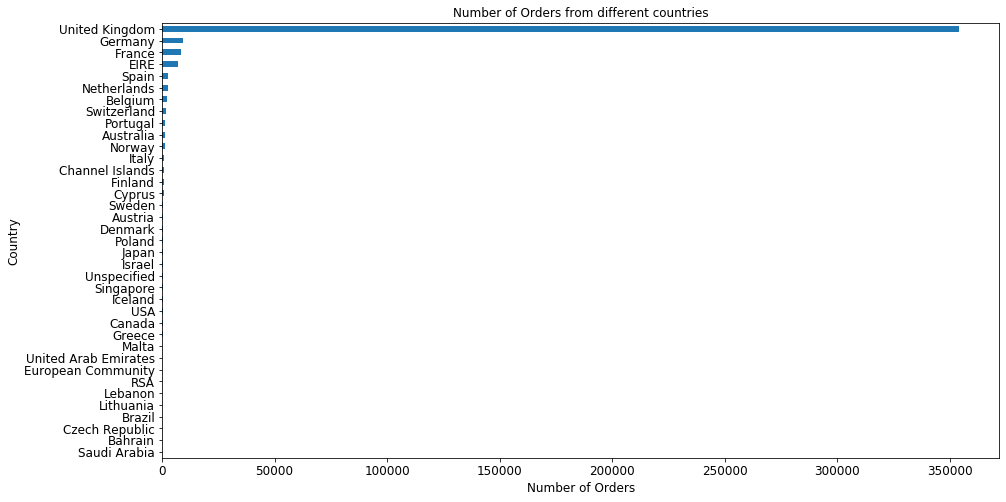

In [12]:
Country_Orders = df2.groupby('Country')['InvoiceNo'].count().sort_values()
plt.subplots(figsize=(15,8))
Country_Orders.plot.barh(fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders from different countries', fontsize=12)
plt.show()

In [13]:
temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12347,537626,31
2,12347,542237,29
3,12347,549222,24
4,12347,556201,18
5,12347,562032,22
6,12347,573511,47
7,12347,581180,11
8,12348,539318,17
9,12348,541998,6


In [14]:
df_check = df2[df2['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df2['CustomerID'] == col[0]) & (df2['Quantity'] == -col[1]) 
                & (df2['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

In [15]:
df_cleaned = df2.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0
entry_to_remove = [] ; doubtfull_entry = []
for index, col in  df2.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df2[(df2['CustomerID'] == col['CustomerID']) &
                         (df2['StockCode']  == col['StockCode']) & 
                         (df2['InvoiceDate'] < col['InvoiceDate']) & 
                         (df2['Quantity']   > 0)].copy()
   
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [16]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,InvoiceDate,Year_Month,Month,Day,Hour,StockCode,Description,Quantity,UnitPrice,AmountSpent,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,2011-01-18 10:01:00,201101,1,2,10,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60,12346,United Kingdom,0,77183.60
14945,537626,2010-12-07 14:57:00,201012,12,2,14,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,1.25,15.00,12347,Iceland,0,15.00
428984,573511,2011-10-31 12:25:00,201110,10,1,12,22621,TRADITIONAL KNITTING NANCY,12,1.65,19.80,12347,Iceland,0,19.80
428985,573511,2011-10-31 12:25:00,201110,10,1,12,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,8,3.29,26.32,12347,Iceland,0,26.32
428986,573511,2011-10-31 12:25:00,201110,10,1,12,23421,PANTRY HOOK SPATULA,12,2.08,24.96,12347,Iceland,0,24.96


In [17]:
df_cleaned.head()

,InvoiceNo,InvoiceDate,Year_Month,Month,Day,Hour,StockCode,Description,Quantity,UnitPrice,AmountSpent,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom,0,15.30
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom,0,20.34
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom,0,22.00
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom,0,20.34
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom,0,20.34


In [18]:
df_cleaned.drop(["InvoiceNo","InvoiceDate","StockCode","Description","Country","QuantityCanceled"], inplace=True, axis=1)

In [19]:
df_cleaned.head()

,Year_Month,Month,Day,Hour,Quantity,UnitPrice,AmountSpent,CustomerID,TotalPrice
0,201012,12,3,8,6,2.55,15.30,17850,15.30
1,201012,12,3,8,6,3.39,20.34,17850,20.34
2,201012,12,3,8,8,2.75,22.00,17850,22.00
3,201012,12,3,8,6,3.39,20.34,17850,20.34
4,201012,12,3,8,6,3.39,20.34,17850,20.34


In [20]:
df_rfm = pd.read_csv("rfm_segmentation.csv")

In [21]:


tag = {"Best Customer":1, "Loyal Customer": 2, "Big Spenders":3, "Almost Lost":4, "Lost Customer":5, "Lost Cheap Customer":6}

In [22]:
df_ml = pd.DataFrame()

In [23]:
def classifier(CustomerID , RFMScore, F_Quartile, M_Quartile, data):
    if(data[RFMScore][CustomerID]=='444'):
        return 1
    elif(data[F_Quartile][CustomerID]==4):
        return 1
    elif(data[M_Quartile][CustomerID]==4):
        return 0
    elif(data[RFMScore][CustomerID]=='244'):
        return 0
    elif(data[RFMScore][CustomerID]=='144'):
        return 0
    elif(data[RFMScore][CustomerID]=='111'):
        return 0
    else:
        return 'Others'

In [24]:
df_rfm.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,2011-01-18,325,1,77183.60,2.0,1,1,4,114
1,12747.0,2011-12-07,2,10,658.89,183.0,4,4,4,444
2,12748.0,2011-12-09,0,196,3739.23,34.0,4,4,4,444
3,12749.0,2011-12-06,3,5,98.35,1140.0,4,3,3,433
4,12820.0,2011-12-06,3,4,58.20,1665.5,4,3,3,433


In [25]:
df_rfm.count()

CustomerID          3863
LastPurshaceDate    3863
Recency             3863
Frequency           3863
Monetary            3863
Rank                3863
R_Quartile          3863
F_Quartile          3863
M_Quartile          3863
RFMScore            3863
dtype: int64

In [26]:
df_rfm["CustomerID"] = df_rfm["CustomerID"].astype("int64")

In [27]:
df_rfm.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346,2011-01-18,325,1,77183.60,2.0,1,1,4,114
1,12747,2011-12-07,2,10,658.89,183.0,4,4,4,444
2,12748,2011-12-09,0,196,3739.23,34.0,4,4,4,444
3,12749,2011-12-06,3,5,98.35,1140.0,4,3,3,433
4,12820,2011-12-06,3,4,58.20,1665.5,4,3,3,433


In [28]:
df_ml = pd.concat([df_rfm, df_ml.reindex(df.index)], axis=1)

In [29]:
df_ml.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,2011-01-18,325.0,1.0,77183.60,2.0,1.0,1.0,4.0,114.0
1,12747.0,2011-12-07,2.0,10.0,658.89,183.0,4.0,4.0,4.0,444.0
2,12748.0,2011-12-09,0.0,196.0,3739.23,34.0,4.0,4.0,4.0,444.0
3,12749.0,2011-12-06,3.0,5.0,98.35,1140.0,4.0,3.0,3.0,433.0
4,12820.0,2011-12-06,3.0,4.0,58.20,1665.5,4.0,3.0,3.0,433.0


In [30]:
df_ml.dropna(inplace=True)

In [31]:
df_ml = df_ml.loc[:,~df_ml.columns.duplicated()]

In [32]:
df_ml.count()

CustomerID          3863
LastPurshaceDate    3863
Recency             3863
Frequency           3863
Monetary            3863
Rank                3863
R_Quartile          3863
F_Quartile          3863
M_Quartile          3863
RFMScore            3863
dtype: int64

In [ ]:
df_ml.drop(["LastPurshaceDate","Amount Spent"], inplace=True, axis=1)

In [33]:
df_ml.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,2011-01-18,325.0,1.0,77183.60,2.0,1.0,1.0,4.0,114.0
1,12747.0,2011-12-07,2.0,10.0,658.89,183.0,4.0,4.0,4.0,444.0
2,12748.0,2011-12-09,0.0,196.0,3739.23,34.0,4.0,4.0,4.0,444.0
3,12749.0,2011-12-06,3.0,5.0,98.35,1140.0,4.0,3.0,3.0,433.0
4,12820.0,2011-12-06,3.0,4.0,58.20,1665.5,4.0,3.0,3.0,433.0


In [ ]:
df_rfm['CustomerClass'] = df_rfm['CustomerID'].apply(classifier, args=('RFMScore','F_Quartile', 'M_Quartile', df_rfm))

In [35]:
df_ml.head()


,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,2011-01-18,325.0,1.0,77183.60,2.0,1.0,1.0,4.0,114.0
1,12747.0,2011-12-07,2.0,10.0,658.89,183.0,4.0,4.0,4.0,444.0
2,12748.0,2011-12-09,0.0,196.0,3739.23,34.0,4.0,4.0,4.0,444.0
3,12749.0,2011-12-06,3.0,5.0,98.35,1140.0,4.0,3.0,3.0,433.0
4,12820.0,2011-12-06,3.0,4.0,58.20,1665.5,4.0,3.0,3.0,433.0


In [36]:
df_ml.tail()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
3858,18280.0,2011-03-07,277.0,1.0,23.70,2574.0,1.0,1.0,2.0,112.0
3859,18281.0,2011-06-12,180.0,1.0,5.04,3612.0,1.0,1.0,1.0,111.0
3860,18282.0,2011-12-02,7.0,2.0,38.25,2109.5,4.0,2.0,2.0,422.0
3861,18283.0,2011-12-06,3.0,16.0,66.75,1526.0,4.0,4.0,3.0,443.0
3862,18287.0,2011-10-28,42.0,3.0,80.40,1315.5,3.0,3.0,3.0,333.0


## Machine Learning

In [285]:
columns = ["Recency", "Frequency", "Monetary", "TotalPrice","Year_Month", "Day", "Hour", "Quantity", "UnitPrice"]
X = df_ml[columns]
Y = df_ml["CustomerClass"]

In [286]:
 from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 

X = sc.fit_transform(X) 

In [287]:
np.save('X', X)
np.save('Y',Y)

In [288]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [289]:
X_train.shape

(160190, 9)

In [290]:
y_train.shape

(160190,)

In [291]:
X = np.load("X.npy", allow_pickle=True)

In [265]:
Y.unique

<bound method Series.unique of 0         0
1         0
2         0
3         0
4         0
         ..
352904    0
352905    0
352906    0
352907    0
352908    0
Name: CustomerClass, Length: 228843, dtype: object>

In [266]:
X.shape

(228843, 9)